Домашнее задание по ML. Во всех содержательных ячейках код мой.

# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация
Дата выдачи: 05.02.2021

Мягкий дедлайн: 01:59MSK 21.02.2021

Жесткий дедлайн: 01:59MSK 24.02.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [ ]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(x_train_pics.shape[0], -1)
x_test = x_test_pics.reshape(x_test_pics.shape[0], -1)

4423680/4422102 [==============================] - 0s 0us/step


__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.linalg import qr
import scipy.stats as stats

In [ ]:
# возьмем 2000 уникальных объектов и составим из них миллион пар
def find_sigma_sq(self):
    n = 1000
    l = len(self.X)
    random_subset = self.rng.choice(l, size=2 * n, replace=False)
    a1 = self.X[random_subset[:n], :].reshape(1, n, -1)
    a2 = self.X[random_subset[n:], :].reshape(n, 1, -1)
    return np.median( ((a1 - a2) ** 2).sum(2) )

def random_params(self):
    w = self.rng.normal(0, 1 / np.sqrt(self.sigma_sq),
                         size=(self.X.shape[1], self.n_features))
    b = self.rng.uniform(-1, 1, size=self.n_features) * np.pi
    return w, b

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin


class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True,
                 classifier='logreg', seed=89, transform=np.cos):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        # для воспроизводимости результатов
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        # чтобы потом можно было поменять косинус
        self.transform = transform
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.X = X
        self.y = y

        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim, random_state=self.seed)
            self.X = self.pca.fit_transform(self.X)
            logging.info('PCA: done')
  
        self.sigma_sq = find_sigma_sq(self)
        logging.info('sigma: done')

        self.w, self.b = random_params(self)
        logging.info('random params: done')

        self.X = self.transform(self.X @ self.w + self.b)
        logging.info('new features: done')

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=False,
                             random_state=self.seed)
        # для другого классификатора в бонусном задании
        elif callable(self.classifier):
            self.model = self.classifier()
        else:
            raise NotImplementedError
        
        logging.info('fitting model...')
        self.model.fit(self.X, self.y)
        clear_output()

    def transform_new_data(self, X):
        if self.use_PCA:
              X = self.pca.transform(X)
        X = self.transform(X @ self.w + self.b)
        return X
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.transform_new_data(X)
        return self.model.predict(X)

In [ ]:
model = RFFPipeline(classifier='logreg')
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8574

Победа😎

__Задание 2. (3 балла)__

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

Сделайте выводы — насколько идея со случайными признаками работает? Сравните как с точки зрения качества, так и с точки зрения скорости обучения и применения.

In [ ]:
# SVM и на линейном ядре учится очень медленно, поэтому
# будем учить все модели на одном подмножестве признаков
np.random.seed(89)
random_subset = np.random.choice(10000, size=6000, replace=False)

In [ ]:
# SVM со случайными признаками
start = time.time()
model = RFFPipeline(classifier='svm')
model.fit(x_train[random_subset, :], y_train[random_subset])
preds = model.predict(x_test)
print(accuracy_score(y_test, preds))
finish = time.time()
print(f'Время выполнения: {finish - start:.0f} с')

0.8383
Время выполнения: 51 с


In [ ]:
# SVM с линейным ядром на исходных данных
start = time.time()
svm = SVC(kernel='linear')
svm.fit(x_train[random_subset, :], y_train[random_subset])
preds = svm.predict(x_test)
print(accuracy_score(y_test, preds))
finish = time.time()
print(f'Время выполнения: {finish - start:.0f} с')

0.7981
Время выполнения: 44 с


In [ ]:
# SVM с гауссовым ядром на исходных данных
start = time.time()
svm = SVC(kernel='rbf')
svm.fit(x_train[random_subset, :], y_train[random_subset])
preds = svm.predict(x_test)
print(accuracy_score(y_test, preds))
finish = time.time()
print(f'Время выполнения: {finish - start:.0f} с')

0.8412
Время выполнения: 60 с


Качество с гауссовым ядром лучше, чем с линейным, и это неудивительно. Однако случайные признаки отлично *приблизили* гауссово ядро. Это пример того, как аппроксимация ядер неплохо работает. Причем уже после понижения размерности, т.е. после потери части данных. В следующем задании посмотрим, что будет, если размерность не понижать.

Но случайные признаки отработали немного быстрее rbf-ядра.

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold

     |████████████████████████████████| 65.8MB 79kB/s 


In [ ]:
params = {
        'learning_rate': 0.1,
        'iterations' : 1000,
        'task_type':'GPU',
        'loss_function' : 'MultiClassOneVsAll',
        'eval_metric' : 'MultiClassOneVsAll',
        'bootstrap_type' : 'Poisson',
        'random_seed' : 89
}

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=89)

In [ ]:
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [ ]:
accuracies = []
for i, (train_index, test_index) in enumerate(kf.split(y_train)):
    model = CatBoostClassifier(**params)
    
    y_learn, y_valid = y_train[train_index], y_train[test_index]
    X_learn, X_valid = x_train_pca[train_index,:], x_train_pca[test_index,:]
    print( "\nFold ", i)
    
    model.fit( X_learn, y_learn, 
               eval_set=(X_valid, y_valid),
               metric_period=200
              )
        
    pred = model.predict(X_valid)
    acc = accuracy_score(y_valid, pred)
    accuracies.append(acc)
    clear_output(wait=True)
    print(f'accuracy: {acc}')

print(f'Cross val accuracy: {np.mean(accuracies)}')

accuracy: 0.8885
Cross val accuracy: 0.8808333333333334


In [ ]:
boosting = CatBoostClassifier(**params)
boosting.fit(x_train_pca, y_train, metric_period=100)
preds = boosting.predict(x_test_pca)
clear_output()
accuracy_score(y_test, preds)

0.871

Бустинг равно оказался лучше, но всего на пару процентов по сравнению с лучшей моделью на случайных признаках - лог регрессией. Такая разница скорее объясняется большим числом гиперпараметров, подбор которых позволяет немного улучшить качество на тесте. Учится он также быстрее, если не учитывать время на выбор гиперпараметров.

(ниже будет пример, как ооочень медленный svm на всех данных даст немного лучше качество)

__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

Попробуем сразу ответить на первые 2 вопроса. Обучим логистическую регрессию (она быстро учится на всех данных) с понижением размерности и без него для нескольких значений `n_features` и посмотрим, что получится:

In [ ]:
n_features = np.array([800, 1000, 1200, 1400, 1600, 1800, 2000])
acc_pca = []
acc_no_pca = []
for n in n_features:
    print(n)
    for array, use_PCA in zip(
        [acc_pca, acc_no_pca],
        [True, False]
    ):
      model = RFFPipeline(n_features=n, use_PCA=use_PCA)
      model.fit(x_train, y_train)
      preds = model.predict(x_test)
      array.append(accuracy_score(y_test, preds))

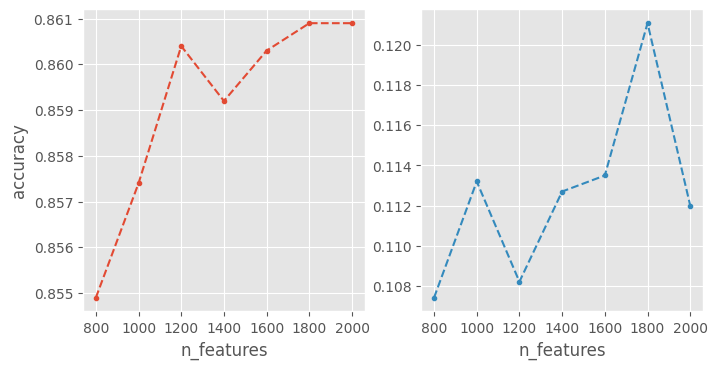

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=[8, 4], dpi=100, sharey=False)

for j, acc in enumerate([acc_pca, acc_no_pca]):
    ax[j].plot(n_features, acc, '.--', c=f'C{j}')
    ax[j].set(xticks=n_features, xlabel='n_features')

ax[0].set_ylabel('accuracy');

Итак, понижение размерности с помощью МГК, как говорил Владимир Ильич Ленин, [архинужно и архиважно](https://www.youtube.com/watch?v=XfaUpBlKLvA&ab_channel=beibotanov). 

Также логистическая регрессия с МГК качество выходит на плато к 2000 случайным признакам.

Теперь научим для тех же `n_features` SVM на $1/6$ данных:

In [ ]:
acc_svm = []
for n in n_features:
    print(n)
    model = RFFPipeline(n_features=n, classifier='svm')
    model.fit(x_train[random_subset, :], y_train[random_subset])
    preds = model.predict(x_test)
    acc_svm.append(accuracy_score(y_test, preds))

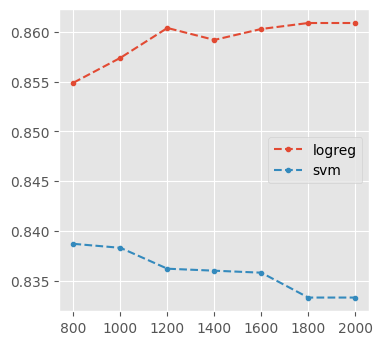

In [ ]:
fig, ax = plt.subplots(figsize=[4, 4], dpi=100, sharey=False)

ax.plot(n_features, acc_pca, '.--', label='logreg')
ax.plot(n_features, acc_svm, '.--', label='svm')
ax.legend();

SVM дает результаты где-то на 2% хуже, но он учился лишь на $1/6$ данных! Еще интересно, что SVM дает лучшее качество на 800 признаках. Попробуем научить его с этим числом признаков на всех данных:

In [ ]:
model = RFFPipeline(n_features=800, classifier='svm')
model.fit(x_train, y_train)
preds = model.predict(x_test)
print(accuracy_score(y_test, preds))

0.8788


Делаем вывод, что выбор между svm и lr - это выбор между чуть лучшим качеством и заметно лучшей скоростью.

### Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [ ]:
def make_linear_transform(self):
    d = self.X.shape[1]
    G = stats.norm.rvs(size=(d, d), random_state=self.seed)
    Q, _ = qr(G)
    S = np.diag(stats.chi.rvs(df=d, size=d, random_state=self.seed))
    W = S @ Q

    # на случай D > d. Будем менять сид, чтобы случайные величины не повторялись
    for j in range(self.m - 1):
        G = stats.norm.rvs(size=(d, d), random_state=self.seed + 1 + j)
        Q, _ = qr(G)
        S = np.diag(stats.chi.rvs(df=d, size=d, random_state=self.seed + 1 + j))
        W = np.hstack((W, S @ Q))
    
    return W / np.sqrt(self.sigma_sq)

In [ ]:
class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_samples=1, new_dim=50, use_PCA=True,
                 classifier='logreg', seed=89):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Orthogonal Random Features approximation and linear classification model.
        
        n_samples, int: сколько раз семплируем матрицу W (для случая D > d)

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.m = n_samples
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier = classifier
        # для воспроизводимости результатов
        self.seed = seed
        self.rng = np.random.RandomState(seed)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        self.X = X
        self.y = y

        if self.use_PCA:
            self.pca = PCA(n_components=self.new_dim, random_state=self.seed)
            self.X = self.pca.fit_transform(self.X)
            logging.info('PCA: done')

        self.sigma_sq = find_sigma_sq(self)
        logging.info('sigma: done')

        self.W = make_linear_transform(self)
        logging.info('random params: done')

        self.X = np.hstack((
            np.cos(self.X @ self.W),
            np.sin(self.X @ self.W)
        ))
        logging.info('new features: done')

        if self.classifier == 'logreg':
            self.model = LogisticRegression()
        elif self.classifier == 'svm':
            self.model = SVC(kernel='linear', probability=False,
                             random_state=self.seed)
        # для другого классификатора в бонусном задании
        elif callable(self.classifier):
            self.model = self.classifier()
        else:
            raise NotImplementedError
        
        logging.info('fitting model...')
        self.model.fit(self.X, self.y)
        clear_output()

    def transform_new_data(self, X):
        if self.use_PCA:
              X = self.pca.transform(X)
        X = np.hstack((
            np.cos(X @ self.W),
            np.sin(X @ self.W)
        ))
        return X
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        X = self.transform_new_data(X)
        return self.model.predict(X)

Сравним с RFF. Логистическая регрессия: было $0.8574$ на всех данных с 1000 фичами.

In [ ]:
# 100 фичей
model = ORFPipeline(classifier='logreg')
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8397

In [ ]:
# 1000 фичей
model = ORFPipeline(classifier='logreg', n_samples=10)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8565

SVM: было $0.8788$ c 800 фичами и дооолгим обучением.

In [ ]:
# 100 фичей
model = ORFPipeline(classifier='svm')
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.852

In [ ]:
# 800 фичей (дооолго)
model = ORFPipeline(classifier='svm', n_samples=8)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8785

В общем, те же Фобос и Деймос, но с другого ракурса😒 Доля правильных ответов отличается только в третьем-четвертом знаке для обоих методов. С другой стороны, в статье говорится про MSE, а лосс не всегда отражается на аккураси.

Мне тут кажется наиболее интересным результат с моделями, в которых мы семплировали одну матрицу размера $l \times l$ и получали сравнимое качество всего с сотней признаков, заметно выигрывая в памяти и скорости вычислений.

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

Возьмем за baseline лог регрессию на всех данных с долей верных ответов $0.8574$. Функции, которые будем использовать:

In [ ]:
@np.vectorize
def identity(x):
    return x

@np.vectorize
def ReLU(x):
    if x > 0:
        return x
    else:
        return 0

@np.vectorize
def f1(x):
    return np.log(1 + np.abs(x)) * np.cos(x)

@np.vectorize
def f2(x):
    z = np.cos(x)
    return z + z ** 2

@np.vectorize
def f3(x):
    return np.cos(x) + np.cos(2 * x)

$f(x) = x$

In [ ]:
model = RFFPipeline(classifier='logreg', transform=identity)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8221

$f(x)=\max\{0, x\}$

In [ ]:
model = RFFPipeline(classifier='logreg', transform=ReLU)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8322

Делаем вывод, что нелинейности (причем желательно сложные) все же помогают🙈 

Дальше будут функции, которые дали лучшее качество.

Что взять лучше косинуса? Можно как-то сделать его "более разнообразным". Например, с помощью "тренда":

$f(x)=\ln(1+|x|)\cos(x)$

In [ ]:
model = RFFPipeline(classifier='logreg', transform=f1)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8669

Или усложнив периодическую функцию:

$f(x)=\cos(x)+\cos^2(x)$

In [ ]:
model = RFFPipeline(classifier='logreg', transform=f2)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.8655

Другой способ усложнить периодическую функцию:

$f(x)=\cos(x)+\cos(2x)$

In [ ]:
model = RFFPipeline(classifier='logreg', transform=f3)
model.fit(x_train, y_train)
preds = model.predict(x_test)
accuracy_score(y_test, preds)

0.872